In [2]:
from typing import Callable

import numpy as np
import matplotlib.pyplot as plt

In [3]:
class Solver:
    def __init__(self, lambda_: float = 1, c: float = 1, 
                    gamma: float = 2, beta: float = -2,
                    t_bond: float = 30, x_bond: float = 10,
                    t_steps: int = 100, x_steps: int = 100) -> None:

        self.gamma = gamma
        self.beta = beta
        self.c = c
        self.lambda_ = lambda_

        self.x_steps = x_steps
        self.t_steps = t_steps
        self.t_bond = t_bond
        self.x_bond = x_bond

        self.x_net = np.linspace(0      ,x_bond, x_steps)
        self.t_net = np.linspace(-t_bond,t_bond, t_steps)
        self.h_x = self.x_net[1] - self.x_net[0]
        self.h_t = self.t_net[1] - self.t_net[0]

    def A_0(self, t: np.ndarray):
        return self.c * self.lambda_/np.cosh(self.lambda_ * t)

    def analytic_sol(self) -> np.ndarray:
        A_surf_mesh = np.zeros((self.x_steps, self.t_steps), dtype=complex)
        for x_ind, x_el in enumerate(self.x_net):
            for t_ind, t_el in enumerate(self.t_net):
                A_surf_mesh[x_ind,t_ind] = self.A_0(t_el)*np.exp(-1j*self.beta*x_el/2 /self.lambda_**2)
        return A_surf_mesh

    def numeric_sol(self) -> np.ndarray:

        def operator_N(a: np.ndarray, coef: float) -> np.ndarray:
            return np.exp(self.gamma*coef*1j*np.abs(a)**2*self.h_x)*a

        def operator_D(a: np.ndarray, coef: float) -> np.ndarray:
            a = np.fft.fft(a)
            w = (np.fft.fftfreq(self.t_steps, self.h_t) * 2 * np.pi)**2
            disp = np.exp(1j / 2 * self.beta * w * self.h_x) * a
            return np.fft.ifft(disp)

        Psi_surf_mesh = np.zeros((self.x_steps, self.t_steps), dtype=complex)
        Psi_surf_mesh[0,:] = self.A_0(self.t_net)
        
        for i in range(1, self.x_steps):

            result = operator_N(Psi_surf_mesh[i-1,:],coef=1)
            result = operator_D(result, 1)
            Psi_surf_mesh[i,:] = result
        
        return Psi_surf_mesh

    def draw_surf_mesh(self, comp_func: Callable) -> None:
        fig = plt.figure("Analytic Solution", figsize= (20,20))
        ax = fig.add_subplot(projection='3d')
        ax.set_xlabel("X")
        ax.set_ylabel("T")
        T, X = np.meshgrid(self.t_net, self.x_net)
        mesh = comp_func()
        ax.plot_surface(T, X, abs(mesh))
        plt.show

    def draw_numeric(self) -> None:
        self.draw_surf_mesh(self.numeric_sol)

    def draw_analytic(self) -> None:
        self.draw_surf_mesh(self.analytic_sol)


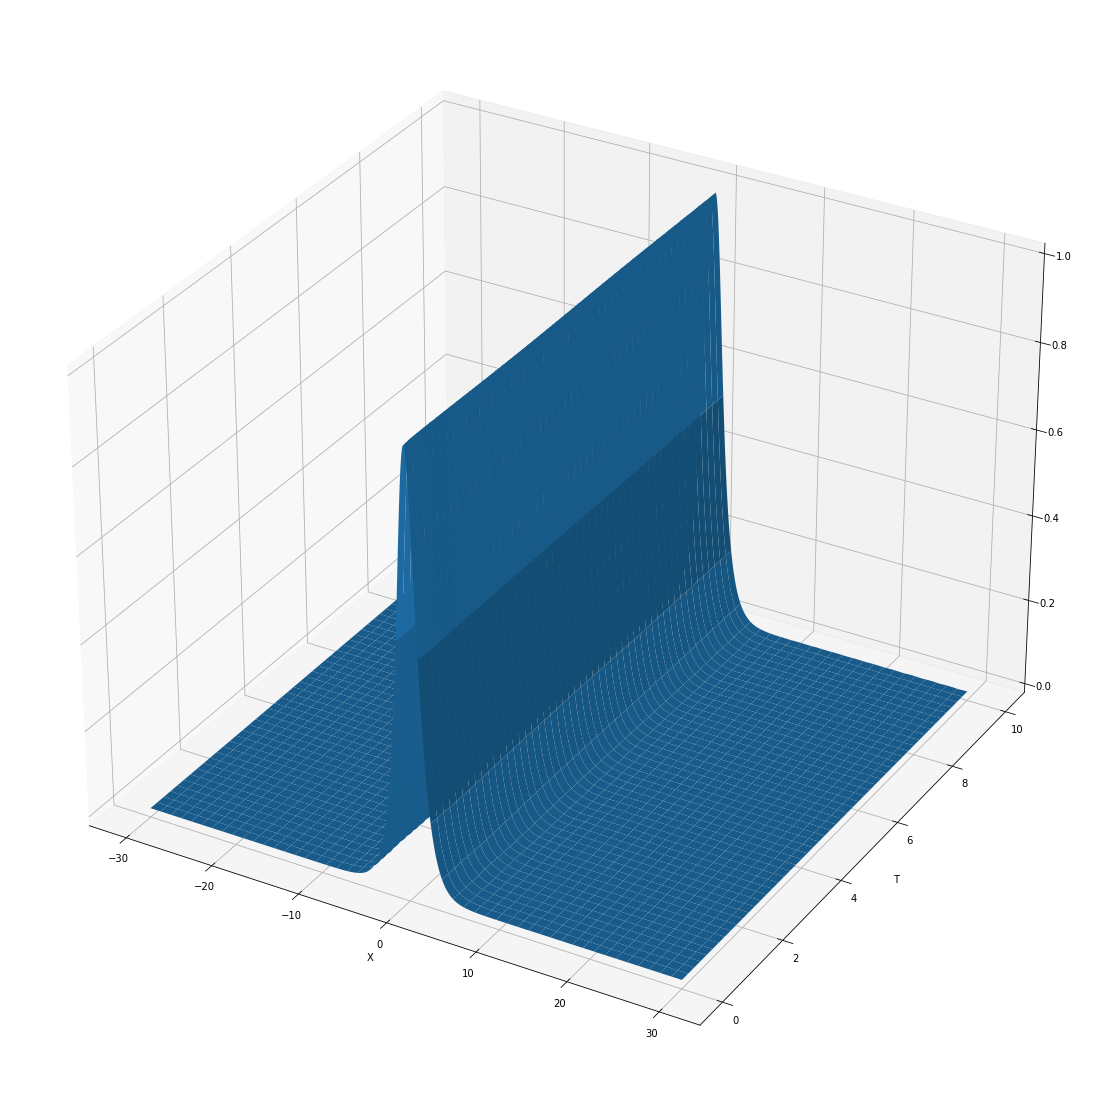

In [4]:
solver = Solver(x_steps=1000, t_steps=1000)
solver.lambda_ = 1
solver.c = 1
solver.draw_numeric()

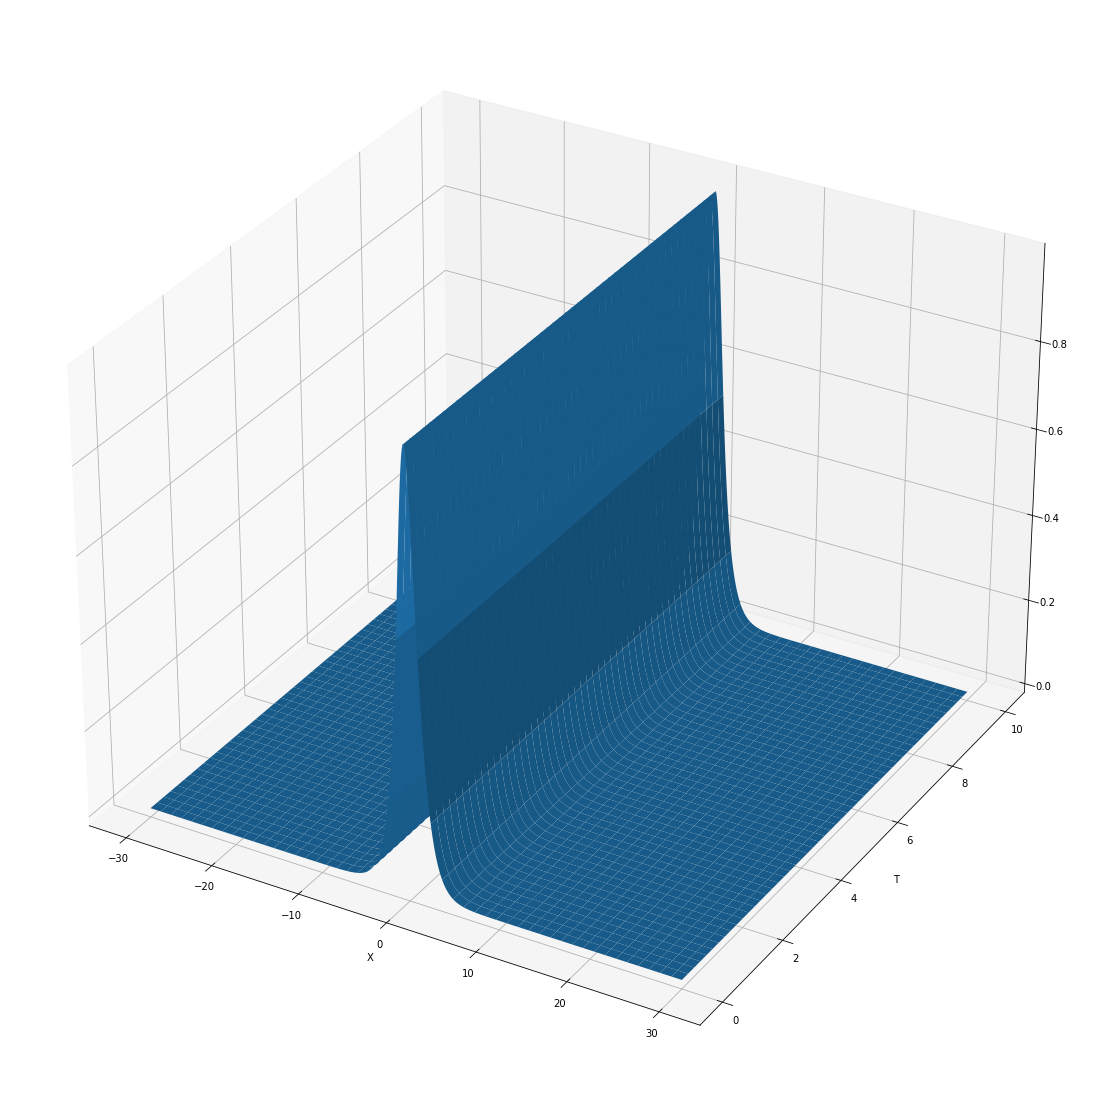

In [5]:
solver.draw_analytic()

In [9]:
x_num_props = 10
t_num_props = 9
RoC_table = np.zeros((x_num_props, t_num_props))

X_STEP_TABLE = [2**(n+1) for n in range(x_num_props)]
T_STEP_TABLE = [2**(n+1) for n in range(t_num_props)]

for i, X in enumerate(X_STEP_TABLE):
    for j, T in enumerate(T_STEP_TABLE):
        solver = Solver(x_steps=X, t_steps=T)
        RoC_table[i,j] = np.max(np.abs(solver.analytic_sol() - solver.numeric_sol()))

In [10]:
x_error = []
for i in range(1,x_num_props):
    x_error.append(RoC_table[i-1, t_num_props-1] / RoC_table[i, t_num_props-1])

print(np.log2(np.array(x_error)))

[ 0.0583357  -0.17770555 -0.46478551  1.22179577  1.78398936  1.95648286
  1.59592107  0.94186653  0.97100699]


In [15]:
t_error = []
for i in range(1,t_num_props):
    t_error.append(RoC_table[x_num_props-1, i-1] / RoC_table[x_num_props-1, i])
    
print(np.log2(np.array(t_error)))

[-2.88538778e+01 -8.24227409e+00 -3.24173534e+00 -1.32200147e+00
  2.02586108e+00  6.79505105e+00  6.64964504e-02 -1.15419477e-02
 -3.98962827e-03 -1.29586428e-03 -4.50571628e-04 -1.74594296e-04]
